In [155]:
import copy
from random import randint, random, choice

In [156]:
class MazeGrid:
    def __init__(self):
        self.height = 7
        self.width = 7
        self.grid = [['.' for _ in range(self.width)] for _ in range(self.height)]
        self.q_values = {}
        self.start_pos = None
        self.goal_pos = None
        
    def generate_maze(self):
        self.start_pos = (randint(0, self.height-1), randint(0, self.width-1))
        self.grid[self.start_pos[0]][self.start_pos[1]] = 'S'
        
        # Finding somewhere to put the Goal
        while True:
            goal_pos = (randint(0, self.height-1), randint(0, self.width-1))
            if goal_pos != self.start_pos:
                self.goal_pos = goal_pos
                self.grid[self.goal_pos[0]][self.goal_pos[1]] = 'G'
                break
        
        
        # Placing walls
        walls_placed = 0
        while walls_placed < 10:
            pos = (randint(0, self.height-1), randint(0, self.width-1))
            if self.grid[pos[0]][pos[1]] == '.':
                self.grid[pos[0]][pos[1]] = 'W'
                walls_placed += 1
        
        for i in range(self.height):
            for j in range(self.width):
                if self.grid[i][j] != 'W':
                    self.q_values[(i, j)] = {'U': 0, 'D': 0, 'L': 0, 'R': 0}

    def reset_q_values(self):    # I add this for cumulative rewards (To keep a same board)
        for i in range(self.height):
            for j in range(self.width):
                if self.grid[i][j] != 'W':
                    self.q_values[(i, j)] = {'U': 0, 'D': 0, 'L': 0, 'R': 0}

    
    def is_valid_move(self, pos):
        if (0 <= pos[0] < self.height and 0 <= pos[1] < self.width and self.grid[pos[0]][pos[1]] != 'W'):
            return True
        return False
    
    def get_next_state(self, state, action):
        # Finds location of the next state
        if action == 'U':
            next_pos = (state[0] - 1, state[1])
        elif action == 'D':
            next_pos = (state[0] + 1, state[1])
        elif action == 'L':
            next_pos = (state[0], state[1] - 1)
        else:
            next_pos = (state[0], state[1] + 1)


        if self.is_valid_move(next_pos):
            return next_pos
        return state
    
    # Reward Function
    def get_reward(self, state, action, next_state):
        if next_state == self.goal_pos:
            return 100.0
        elif next_state == state:
            return -5.0
        return -1.0
    
    def print_maze(self):
        for row in self.grid:
            [print(item, end='  ') for item in row]
            print()
        print()

In [157]:
class Agent:
    def __init__(self, game, alpha = 0.1, gamma = 0.9, epsilon = 0.1, max_episode_length = 10000):
        self.game = game
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_episode_length = max_episode_length
        
    def choose_action(self, state, is_training = True):
        if is_training and random() < self.epsilon:
            return choice(['U', 'D', 'L', 'R'])
        
        q_values = self.game.q_values[state]
        max_action = None
        max_value = float('-inf')
        for action, value in q_values.items():
            if value > max_value:
                max_value = value
                max_action = action

        return max_action
    
    def train(self, episodes):
        total_rewards = []

        for _ in range(episodes):
            current_state = self.game.start_pos
            cumulative_rewards = 0
            
            actions_done = 0
            while actions_done <= self.max_episode_length:
                action = self.choose_action(current_state)
                next_state = self.game.get_next_state(current_state, action)
                reward = self.game.get_reward(current_state, action, next_state)

                cumulative_rewards += reward
                
                current_q = self.game.q_values[current_state][action]
                next_max_q = max(self.game.q_values[next_state].values())
                
                new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)
                self.game.q_values[current_state][action] = new_q
                
                current_state = next_state
                actions_done += 1

                if current_state == self.game.goal_pos:
                    break

            total_rewards.append(cumulative_rewards)
        
        return total_rewards
    
    def get_best_path(self):
        path = [self.game.start_pos]
        current_state = self.game.start_pos
        
        while current_state != self.game.goal_pos:
            action = self.choose_action(current_state, is_training=False)
            next_state = self.game.get_next_state(current_state, action)
            
            if next_state == current_state:
                break
                
            path.append(next_state)
            current_state = next_state
            
            if len(path) > self.game.width *self.game.height:
                break
        
        return path


In [158]:
import os
import time
import tkinter as tk
from tkinter import Canvas

In [159]:
def animate_path(grid, start_pos, goal_pos, optimal_path):
    maze_with_path = copy.deepcopy(grid)

    for pos in optimal_path:
        maze_with_path[start_pos[0]][start_pos[1]] = '.'
        maze_with_path[pos[0]][pos[1]] = 'S'
        start_pos = pos

        os.system('cls' if os.name == 'nt' else 'clear')

        print()
        for row in maze_with_path:
            [print(item, end='  ') for item in row]
            print()

        time.sleep(0.5)
        try:
            if os.name == 'nt':
                import winsound
                winsound.Beep(250, 250)
            else:
                import sys
                sys.stdout.write('\a')
                sys.stdout.flush()
        except Exception as e:
            pass

        print()
        if pos == goal_pos:
            for row in maze_with_path:
                [print(item, end='  ') for item in row]
                print()
            print("\nGoal Reached! 🎉")
            return

In [160]:
def normalize_green(value, min_val, max_val):
    if max_val - min_val == 0:
        return 0
    return int(255 * (value - min_val) / (max_val - min_val))

def visualize_q_values(q_values, grid_size):
    root = tk.Tk()
    
    cell_size = 100
    canvas = Canvas(root, width=grid_size * cell_size, height=grid_size * cell_size)
    canvas.pack()
    
    all_q_values = [value for state_values in q_values.values() for value in state_values.values()]
    min_q, max_q = min(all_q_values), max(all_q_values)
    
    for (row, col), actions in q_values.items():
        x1, y1 = col * cell_size, row * cell_size
        x2, y2 = x1 + cell_size, y1 + cell_size
        
        canvas.create_rectangle(x1, y1, x2, y2, fill="black", outline="white")
        
        colors = {action: f'#{(255 - normalize_green(actions[action], min_q, max_q)):02x}ff{(255 - normalize_green(actions[action], min_q, max_q)):02x}' for action in actions}
        
        canvas.create_text(x1 + cell_size / 2, y1 + cell_size / 2, text=f"X", fill="gray", font="Times 90")
        canvas.create_text(x1 + cell_size / 2, y1 + 10, text=f"{actions['U']:.2f}", fill=colors['U'], anchor='n')
        canvas.create_text(x1 + cell_size / 2, y2 - 10, text=f"{actions['D']:.2f}", fill=colors['D'], anchor='s')
        canvas.create_text(x1 + 10, y1 + cell_size / 2, text=f"{actions['L']:.2f}", fill=colors['L'], anchor='w')
        canvas.create_text(x2 - 10, y1 + cell_size / 2, text=f"{actions['R']:.2f}", fill=colors['R'], anchor='e')
    
    root.mainloop()

In [161]:
game = MazeGrid()
game.generate_maze()
print("Initial Maze:")
game.print_maze()

agent = Agent(game)
training_episodes = 1000
agent.train(training_episodes)

optimal_path = agent.get_best_path()
print("\nBest path found:", optimal_path)

maze_with_path = copy.deepcopy(game.grid)

print()

animate_path(maze_with_path, game.start_pos, game.goal_pos, optimal_path)

print()

print("\nFinal Q-values for each state:")
for state, q_values in game.q_values.items():
    print(f"State {state}: {q_values}")


visualize_q_values(game.q_values, game.height)

Initial Maze:
.  W  W  .  .  .  .  
W  .  W  W  .  .  .  
W  .  .  .  .  .  .  
.  .  .  .  .  .  S  
.  .  .  .  .  .  W  
.  W  W  .  .  .  .  
.  .  .  W  .  .  G  


Best path found: [(3, 6), (3, 5), (4, 5), (5, 5), (5, 6), (6, 6)]


.  W  W  .  .  .  .  
W  .  W  W  .  .  .  
W  .  .  .  .  .  .  
.  .  .  .  .  .  S  
.  .  .  .  .  .  W  
.  W  W  .  .  .  .  
.  .  .  W  .  .  G  


.  W  W  .  .  .  .  
W  .  W  W  .  .  .  
W  .  .  .  .  .  .  
.  .  .  .  .  S  .  
.  .  .  .  .  .  W  
.  W  W  .  .  .  .  
.  .  .  W  .  .  G  


.  W  W  .  .  .  .  
W  .  W  W  .  .  .  
W  .  .  .  .  .  .  
.  .  .  .  .  .  .  
.  .  .  .  .  S  W  
.  W  W  .  .  .  .  
.  .  .  W  .  .  G  


.  W  W  .  .  .  .  
W  .  W  W  .  .  .  
W  .  .  .  .  .  .  
.  .  .  .  .  .  .  
.  .  .  .  .  .  W  
.  W  W  .  .  S  .  
.  .  .  W  .  .  G  


.  W  W  .  .  .  .  
W  .  W  W  .  .  .  
W  .  .  .  .  .  .  
.  .  .  .  .  .  .  
.  .  .  .  .  .  W  
.  W  W  .  .  .  S  
.  .  

KeyboardInterrupt: 

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,

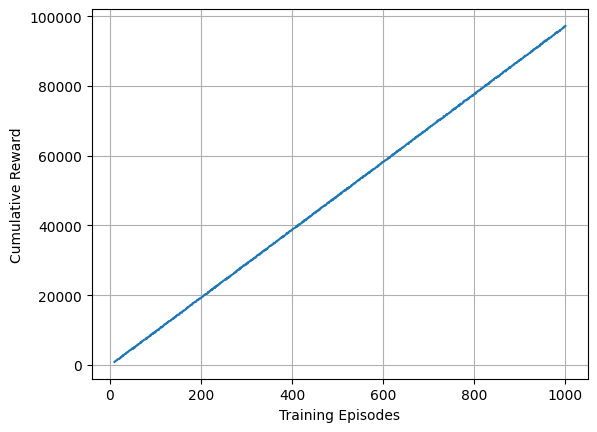

In [174]:
import matplotlib.pyplot as plt

game = MazeGrid()
game.generate_maze()

episode_numbers = []
cumulative_rewards = []

for training_episodes in range(10, 1001):
    game.reset_q_values()
    agent = Agent(game)
    rewards = agent.train(training_episodes)
    
    cumulative_rewards.append(sum(rewards))
    episode_numbers.append(training_episodes)

print(episode_numbers, cumulative_rewards)

plt.plot(episode_numbers, cumulative_rewards)
plt.xlabel('Training Episodes')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()